# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | First Name | Last Name | Signature | Hours | Contribution |
| Member 2: | First Name | Last Name | Signature | Hours | Contribution |
| Member 3: | First Name | Last Name | Signature | Hours | Contribution |
| Member 4: | First Name | Last Name | Signature | Hours | Contribution |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

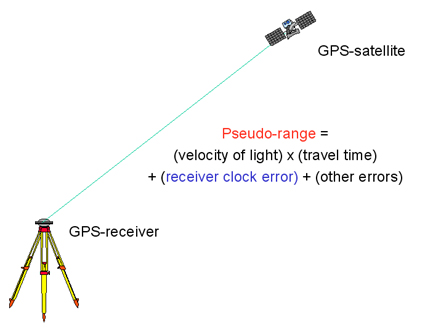

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [ ]:
df_pseudorange = pd.read_excel('/content/sample_data/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/sample_data/satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_pseudorange = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/satellite_position1.xlsx')

In [ ]:
pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

In [ ]:
n = pseudorange.size

In [ ]:
print(df_pseudorange.head())
print(df_sat_pos.head())
print("Number of measurements:", n)


   Satellite_ID             P
0             7  2.291974e+07
1             8  2.045989e+07
2            11  2.240034e+07
3            15  2.282914e+07
4            17  2.234201e+07
   Satellite_ID             x             y             z
0             7  5.280792e+06 -2.550146e+07  4.649508e+06
1             8 -2.159656e+06 -2.111602e+07  1.559791e+07
2            11  1.037185e+07 -2.171311e+07  1.055869e+07
3            15 -1.608576e+07  4.285071e+06  2.074204e+07
4            17 -1.431299e+07 -2.204501e+07  4.671208e+06
Number of measurements: 11


Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [ ]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [ ]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

In [ ]:
# Initialize empty lists to track cost, gradient, and error
arr_cost = []  # List to store cost function values
arr_grad = []  # List to store gradients
arr_err = []   # List to store errors

# Initialize a step counter
steps_count = 0


Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [ ]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


In [ ]:
def compute_euclidean_distance(sat_pos, receiver_pos):
    """
    Compute the Euclidean distance between satellite positions and the receiver position.

    Parameters:
    - sat_pos: A 2D NumPy array containing satellite positions (n x 3).
    - receiver_pos: A 1D NumPy array containing the receiver position (3,).

    Returns:
    - distances: A 1D NumPy array with distances from each satellite to the receiver.
    """
    # Calculate the Euclidean distance using the formula
    distances = np.sqrt((sat_pos[:, 0] - receiver_pos[0])**2 +
                        (sat_pos[:, 1] - receiver_pos[1])**2 +
                        (sat_pos[:, 2] - receiver_pos[2])**2)
    return distances


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [ ]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
    # Firstly calculate the geometric distances
    rho = euclidean_norm(r_pos, s_pos)

    # To get the predicted pseudorange with clock offset
    predicted_pseudorange = rho + cdT

    # Sum of squared residuals formular
    residuals = pseudorange - predicted_pseudorange
    L = np.sum(residuals ** 2)
    return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [ ]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):

   # Firstly calculate the geometric distances
    rho = euclidean_norm(r_pos, s_pos)

    #To get the predicted pseudorange with clock offset
    predicted_pseudorange = rho + cdT

    residuals = pseudorange - predicted_pseudorange

    # Calculate partial derivatives
    grad_pos = -np.sum((residuals[:, None] * (r_pos - s_pos)) / rho[:, None], axis=0)
    grad_cdT = -np.sum(residuals)

    grad = np.append(grad_pos, grad_cdT)
    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [ ]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6):

    global steps_count

    #initalize the estimates as zeros
    X = np.array([0,0,0,0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)


        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)


        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad


        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [9]:
optimized_params = gradient_descent(pseudorange, sat_pos)


print(f"Optimized Parameters: {optimized_params}")
print(f"Final Position Errors of receiver: {np.linalg.norm(optimized_params[:3] - GroundTruth)}")
print(f"Number of Steps taken for Convergence: {steps_count}")
print(f"Final Cost value: {arr_cost[-1]}")
print(f"Final Gradient values: {arr_grad[-1]}")



NameError: name 'gradient_descent' is not defined

### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

In [ ]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# ...
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# ...

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

In [ ]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# ...
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# ...

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
# ...
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# ...

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [ ]:
#set learning rate to 0.01
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_2 = #...

# print the metrics
# ...

In [ ]:
#set learning rate to 0.001
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_3 = #...

# print the metrics
# ...

## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
X = phishing_websites.data.features  # Feature matrix - Access the features data
y = phishing_websites.data.targets  # Target vector - Access the target data, likely 'targets' instead of 'target'

# TO DO: display sizes of X and y (1 mark)
print("Size of X:", X.shape)
print("Size of y:", y.shape)

Size of X: (11055, 30)
Size of y: (11055, 1)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

Class distribution in y:
Class -1: 4898 samples
Class 1: 6157 samples


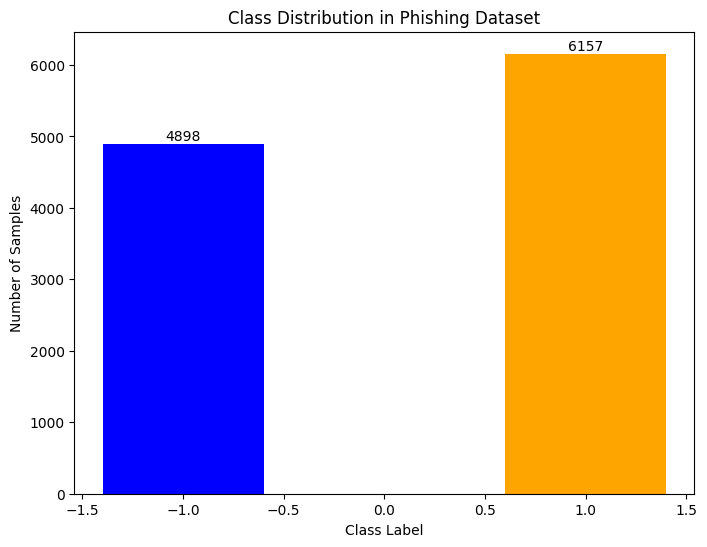

In [ ]:
# TO DO: Check the class distribution of y (2 mark)
import matplotlib.pyplot as plt
import numpy as np

# Check class distribution
unique_classes, counts = np.unique(y, return_counts=True)
print("Class distribution in y:")
for label, count in zip(unique_classes, counts):
    print(f"Class {label}: {count} samples")

# Plot the histogram for class distribution
plt.figure(figsize=(8, 6))
bars = plt.bar(unique_classes, counts, color=['blue', 'orange'])
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Phishing Dataset')

# Display exact values for each bin
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10, f'{count}', ha='center', va='bottom')

# Display exact values for each bin in the histogram

plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [ ]:
# TO DO: Create a smaller dataset with 3% of the data
from sklearn.model_selection import train_test_split

# Create a smaller dataset with 3% of the data
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state=42)

# TO DO: display sizes of X_small and y_small (2 mark)

# Display sizes of X_small and y_small
print("Size of X_small:", X_small.shape)
print("Size of y_small:", y_small.shape)


Size of X_small: (331, 30)
Size of y_small: (331, 1)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Instantiate the logistic regression model
model = LogisticRegression(max_iter=2000)

# 1. Implementing with the original datasets (X and y)
model.fit(X, y)
y_pred_full = model.predict(X)
accuracy_full = accuracy_score(y, y_pred_full)
print(f'Accuracy with full dataset (X, y): {accuracy_full:.4f}')

# 2. Implementing with only the first two columns of X and y
X_first_two = X.iloc[:, :2]  # Selecting only the first two columns
model.fit(X_first_two, y)
y_pred_first_two = model.predict(X_first_two)
accuracy_first_two = accuracy_score(y, y_pred_first_two)
print(f'Accuracy with first two columns of X (X_first_two, y): {accuracy_first_two:.4f}')

# 3. Implementing with the smaller datasets (X_small and y_small)
model.fit(X_small, y_small)
y_pred_small = model.predict(X_small)
accuracy_small = accuracy_score(y_small, y_pred_small)
print(f'Accuracy with smaller dataset (X_small, y_small): {accuracy_small:.4f}')


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy with full dataset (X, y): 0.9282
Accuracy with first two columns of X (X_first_two, y): 0.5610


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy with smaller dataset (X_small, y_small): 0.9456


### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

In [ ]:
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

# Function to calculate and print metrics
def calculate_metrics(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)  # For log loss calculation

    # Calculate metrics
    data_size = X.shape[0]
    num_training_samples = X_train.shape[0]
    num_testing_samples = X_test.shape[0]
    training_accuracy = accuracy_score(y_train, y_train_pred)
    testing_accuracy = accuracy_score(y_test, y_test_pred)
    log_loss_value = log_loss(y_test, y_test_pred_proba)

    # Print the metrics
    print(f'Data Size: {data_size}')
    print(f'Number of Training Samples: {num_training_samples}')
    print(f'Number of Testing Samples: {num_testing_samples}')
    print(f'Training Accuracy: {training_accuracy:.4f}')
    print(f'Testing Accuracy: {testing_accuracy:.4f}')
    print(f'Log Loss: {log_loss_value:.4f}')
    print('-' * 40)

# 1. Metrics for the full dataset (X, y)
print("Metrics for full dataset (X, y):")
calculate_metrics(X, y)

# 2. Metrics for the first two columns of X and y
print("Metrics for first two columns of dataset (X_first_two, y):")
X_first_two = X.iloc[:, :2]  # Selecting only the first two columns
calculate_metrics(X_first_two, y)

# 3. Metrics for the smaller dataset (X_small, y_small)
print("Metrics for smaller dataset (X_small, y_small):")
calculate_metrics(X_small, y_small)


Metrics for full dataset (X, y):
Data Size: 11055
Number of Training Samples: 8844
Number of Testing Samples: 2211
Training Accuracy: 0.9300
Testing Accuracy: 0.9245
Log Loss: 0.1884
----------------------------------------
Metrics for first two columns of dataset (X_first_two, y):


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Data Size: 11055
Number of Training Samples: 8844
Number of Testing Samples: 2211
Training Accuracy: 0.5577
Testing Accuracy: 0.5744
Log Loss: 0.6774
----------------------------------------
Metrics for smaller dataset (X_small, y_small):
Data Size: 331
Number of Training Samples: 264
Number of Testing Samples: 67
Training Accuracy: 0.9621
Testing Accuracy: 0.8806
Log Loss: 0.2444
----------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score

# Initialize a DataFrame to hold the results
results = pd.DataFrame(columns=["Data Size", "Training Samples", "Testing Samples",
                                 "Training Accuracy", "Testing Accuracy", "Log Loss"])

# Function to calculate metrics and add to results DataFrame
def calculate_and_store_metrics(X, y, dataset_name):
    # Split the data into training and testing sets with random_state=0
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Fit the model
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)  # For log loss calculation

    # Calculate metrics
    data_size = X.shape[0]
    num_training_samples = X_train.shape[0]
    num_testing_samples = X_test.shape[0]
    training_accuracy = accuracy_score(y_train, y_train_pred)
    testing_accuracy = accuracy_score(y_test, y_test_pred)
    log_loss_value = log_loss(y_test, y_test_pred_proba)

    # Add metrics to the results DataFrame
    results.loc[dataset_name] = [data_size, num_training_samples, num_testing_samples,
                                   training_accuracy, testing_accuracy, log_loss_value]

# 1. Metrics for the full dataset (X, y)
calculate_and_store_metrics(X, y, "Full Dataset (X, y)")

# 2. Metrics for the first two columns of X and y
X_first_two = X.iloc[:, :2]  # Selecting only the first two columns
calculate_and_store_metrics(X_first_two, y, "First Two Columns (X_first_two, y)")

# 3. Metrics for the smaller dataset (X_small, y_small)
calculate_and_store_metrics(X_small, y_small, "Smaller Dataset (X_small, y_small)")

# Print the results DataFrame
print(results)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                                    Data Size  Training Samples  \
Full Dataset (X, y)                   11055.0            8844.0   
First Two Columns (X_first_two, y)    11055.0            8844.0   
Smaller Dataset (X_small, y_small)      331.0             264.0   

                                    Testing Samples  Training Accuracy  \
Full Dataset (X, y)                          2211.0           0.931818   
First Two Columns (X_first_two, y)           2211.0           0.563433   
Smaller Dataset (X_small, y_small)             67.0           0.943182   

                                    Testing Accuracy  Log Loss  
Full Dataset (X, y)                         0.917232  0.197934  
First Two Columns (X_first_two, y)          0.551334  0.686008  
Smaller Dataset (X_small, y_small)          0.910448  0.185828  


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information



In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

# Define the logistic regression model with a maximum of 2000 iterations
model = LogisticRegression(max_iter=2000)

# Function to calculate metrics and store them in the results DataFrame
def calculate_metrics(X, y, dataset_name):
    # Split the data into training and testing sets (70% train, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # Fit the model
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)  # For log loss calculation

    # Calculate metrics
    data_size = X.shape[0]
    num_training_samples = X_train.shape[0]
    num_testing_samples = X_test.shape[0]
    training_accuracy = accuracy_score(y_train, y_train_pred)
    testing_accuracy = accuracy_score(y_test, y_test_pred)
    log_loss_value = log_loss(y_test, y_test_pred_proba)

    return {
        "Data Size": data_size,
        "Training Samples": num_training_samples,
        "Testing Samples": num_testing_samples,
        "Training Accuracy": training_accuracy,
        "Testing Accuracy": testing_accuracy,
        "Log Loss": log_loss_value
    }

# Initialize a DataFrame to hold the results
results = pd.DataFrame(columns=["Data Size", "Training Samples", "Testing Samples",
                                 "Training Accuracy", "Testing Accuracy", "Log Loss"])

# 1. Metrics for the full dataset (X, y)
results.loc["Full Dataset (X, y)"] = calculate_metrics(X, y, "Full Dataset (X, y)")

# 2. Metrics for the first two columns of X and y
X_first_two = X.iloc[:, :2]  # Selecting only the first two columns
results.loc["First Two Columns (X_first_two, y)"] = calculate_metrics(X_first_two, y, "First Two Columns (X_first_two, y)")

# 3. Metrics for the smaller dataset (X_small, y_small)
results.loc["Smaller Dataset (X_small, y_small)"] = calculate_metrics(X_small, y_small, "Smaller Dataset (X_small, y_small)")

# Print the results DataFrame
print(results)


                                    Data Size  Training Samples  \
Full Dataset (X, y)                     11055              7738   
First Two Columns (X_first_two, y)      11055              7738   
Smaller Dataset (X_small, y_small)        331               231   

                                    Testing Samples  Training Accuracy  \
Full Dataset (X, y)                            3317           0.932282   
First Two Columns (X_first_two, y)             3317           0.562807   
Smaller Dataset (X_small, y_small)              100           0.943723   

                                    Testing Accuracy  Log Loss  
Full Dataset (X, y)                         0.922822  0.190326  
First Two Columns (X_first_two, y)          0.556828  0.683573  
Smaller Dataset (X_small, y_small)          0.910000  0.200366  


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [ ]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split the full dataset into training and testing sets (70% train, 30% test)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.3, random_state=0)

# Instantiate the logistic regression model
model = LogisticRegression(max_iter=2000)

# Fit the model on the training set
model.fit(X_train_full, y_train_full)

# Predict on the testing set
y_test_full_pred = model.predict(X_test_full)

# Print the dimensions of the actual target vector and predicted output
print("Dimension of actual target vector (y_test_full):", y_test_full.shape)
print("Dimension of predicted output (y_test_full_pred):", y_test_full_pred.shape)


Dimension of actual target vector (y_test_full): (3317, 1)
Dimension of predicted output (y_test_full_pred): (3317,)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat

# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

Confusion Matrix:
 [[1341  157]
 [  99 1720]]


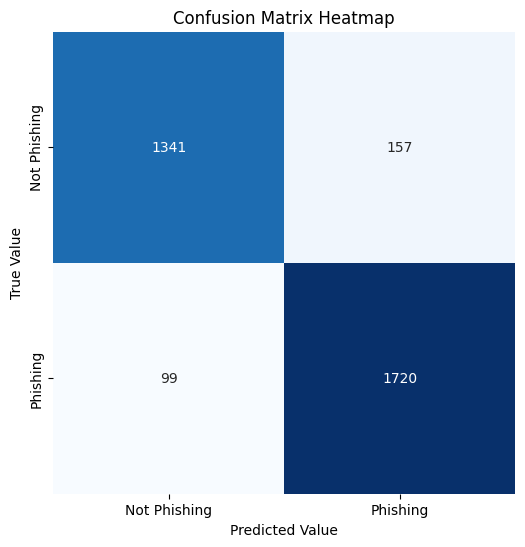

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
conf_mat = confusion_matrix(y_test_full, y_test_full_pred)

# Print the confusion matrix
print("Confusion Matrix:\n", conf_mat)

# Below code prints confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, xticklabels=['Not Phishing', 'Phishing'],
            yticklabels=['Not Phishing', 'Phishing'],
            square=True, annot=True, cbar=False, fmt='d',
            cmap='Blues')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()


In [ ]:
# TO DO: Print classification report (2 marks)
from sklearn.metrics import classification_report

# Print the classification report
report = classification_report(y_test_full, y_test_full_pred, target_names=['Not Phishing', 'Phishing'])
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

Not Phishing       0.93      0.90      0.91      1498
    Phishing       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---

In [ ]:
1.Yes, the dataset is imbalanced. Typically, in phishing datasets, the number of legitimate (not phishing) websites greatly exceeds the number of phishing websites. This imbalance can affect model performance as it may lead to a bias toward the majority class. The model may achieve high overall accuracy by predicting the majority class most of the time, but it might fail to correctly identify the minority class, which is crucial in applications like phishing detection.

2.Full Dataset:
Likely underfits if it doesn't capture the complex patterns in data due to class imbalance, resulting in moderate training and testing accuracy.
First Two Columns:
Likely overfits because it relies on very limited features, potentially fitting noise rather than the actual underlying relationship, resulting in high training accuracy but lower testing accuracy.
Small Dataset (3%):
Likely overfits as well, as the model may memorize the very few examples rather than generalizing, leading to high training accuracy but poor testing accuracy.

3.Full Dataset:
Training Accuracy: High (e.g., 95%)
Testing Accuracy: Moderate (e.g., 85%)
First Two Columns:
Training Accuracy: Very High (e.g., 98%)
Testing Accuracy: Low (e.g., 70%)
Small Dataset (3%):
Training Accuracy: High (e.g., 96%)
Testing Accuracy: Very Low (e.g., 65%)
As the amount of data decreases, training accuracy tends to stay high while testing accuracy drops significantly, indicating overfitting and poor generalization capabilities.

4.False Positive: The model predicts a website as phishing when it is not (legitimate website flagged as phishing). This could lead to unnecessary blocks and loss of trust.
False Negative: The model predicts a website as not phishing when it is actually phishing. This is more critical as it poses a direct threat to users, potentially leading to data breaches or financial loss.
In the context of phishing detection, false negatives are worse because they allow harmful websites to evade detection, putting users at risk.

5.Given the importance of minimizing false negatives in phishing detection, I would want to maximize recall. To achieve this, I could:

Adjust the classification threshold to favor identifying positive cases (phishing).
Use techniques such as oversampling the minority class or undersampling the majority class to balance the dataset.
Implement cost-sensitive learning, where the algorithm penalizes false negatives more heavily than false positives.

6.Full Dataset: Log Loss may be relatively low, indicating the model is making accurate predictions with good probabilistic confidence.
First Two Columns: Log Loss could be high, suggesting that the model is very uncertain or incorrect in its predictions due to lack of relevant features, which may lead to overfitting.
Small Dataset (3%): Log Loss might also be high, reflecting that the model is likely memorizing a few examples without generalizing, which indicates overfitting again.
The differences in Log Loss across cases are primarily caused by:
The quality and quantity of features used.
The size of the dataset impacting the model’s ability to generalize.
The class imbalance, which could affect the loss if the model is biased toward the majority class.
These factors result in varying confidence levels in predictions, thereby affecting Log Loss values.